# Imports

In [3]:
import numpy as np

from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error , mean_squared_error

import tensorflow as tf
from tensorflow.keras.layers import LSTM , Dropout , Dense
from tensorflow.keras.models import Sequential

import pandas as pd 
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('../../data/EQ_daily/AXISBANKEQ.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.index = df['Date']
df.drop(df[df['High']==df['Low']].index , axis=0 , inplace=True)
df.head()

,Ticker,Date,Time,Open,High,Low,Close,Volume,OI
Date,,,,,,,,,
1998-12-02,AXISBANKEQ,1998-12-02,00:00:00,3.36,3.44,3.32,3.39,75000,0
1998-12-03,AXISBANKEQ,1998-12-03,00:00:00,3.89,3.89,3.36,3.40,538000,0
1998-12-04,AXISBANKEQ,1998-12-04,00:00:00,3.37,3.39,3.26,3.31,182000,0
1998-12-07,AXISBANKEQ,1998-12-07,00:00:00,3.31,3.35,3.29,3.33,112500,0
1998-12-08,AXISBANKEQ,1998-12-08,00:00:00,3.27,3.32,3.20,3.25,271000,0


In [5]:
df.drop(['Ticker' , 'Date' ,'Time', 'Volume' , 'OI '] , axis=1 , inplace=True)
df = df.loc['2009-01':]
data = df.copy()

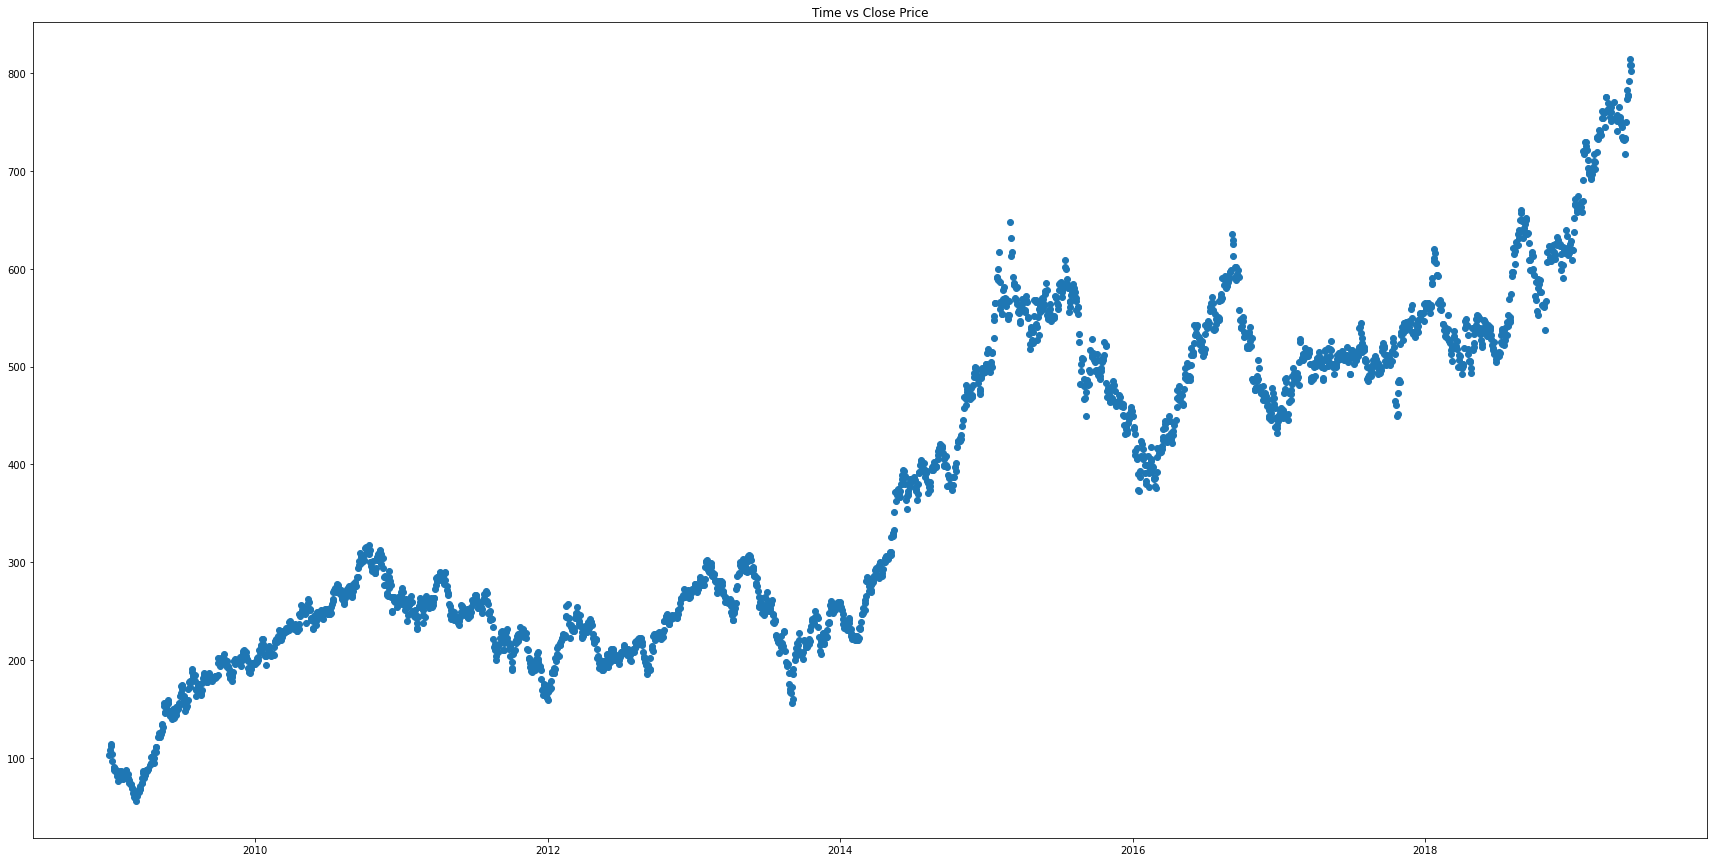

In [6]:
plt.figure(figsize=(30 , 15))
plt.scatter(df.index , df['Close'])
plt.title('Time vs Close Price')
plt.show()

In [7]:
data.isnull().sum()

Open     0
High     0
Low      0
Close    0
dtype: int64

In [8]:
data[data['High'] == data['Low']]

,Open,High,Low,Close
Date,,,,


In [9]:
data[data['Close'] == data['Open']]

,Open,High,Low,Close
Date,,,,
2009-07-24,178.79,181.38,176.00,178.79
2016-06-17,526.90,533.90,524.70,526.90
2016-10-28,486.90,494.00,484.55,486.90
2017-12-26,555.00,557.25,550.30,555.00


In [10]:
df.loc['2009-07']

,Open,High,Low,Close
Date,,,,
2009-07-01,167.60,175.98,166.03,173.88
2009-07-02,175.00,176.58,167.32,170.74
2009-07-03,169.42,175.20,167.48,174.67
2009-07-06,176.02,177.00,156.32,158.88
2009-07-07,159.60,165.20,159.00,163.35
2009-07-08,160.24,163.20,154.31,157.30
2009-07-09,155.27,159.40,149.02,152.99
2009-07-10,154.00,157.40,145.22,147.65
2009-07-13,143.80,154.26,141.42,151.08


In [11]:
# Training and testing data
train_size = int(len(data) *0.80)
train = data[:train_size]
test = data[train_size :]

In [12]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_close = scaler.fit_transform(np.array(train['Close']).reshape(-1,1))

In [13]:
scaled_open = scaler.transform(np.array(train['Open']).reshape(-1,1))
scaled_high = scaler.transform(np.array(train['High']).reshape(-1,1))
scaled_low = scaler.transform(np.array(train['Low']).reshape(-1,1))

In [14]:
open_list = []
close_list = []
high_list = []
low_list = []
for i in range(len(scaled_open)):
    open_list.append(scaled_open[i])
    high_list.append(scaled_high[i])
    low_list.append(scaled_low[i])
    close_list.append( scaled_close[i])

In [15]:
open_arr = np.array(open_list).reshape(-1,1)
high_arr = np.array(high_list).reshape(-1,1)
low_arr = np.array(low_list).reshape(-1,1)
close_arr = np.array(close_list).reshape(-1,1)

In [16]:
scaled_data = pd.DataFrame(open_arr , columns=['Open'])

In [17]:
scaled_data['High'] = high_arr
scaled_data['Low'] = low_arr
scaled_data['Close'] = close_arr

In [18]:
scaled_train = np.array(scaled_data)

In [19]:
X_train = []
y_train = []

for x in range(60,len(scaled_train)-1):
    temp = []
    for i in scaled_train[x-60 :x,]:
        temp.append(i[0] )
        temp.append(i[1])
        temp.append( i[2])
        temp.append(i[3])
        
    X_train.append(temp)
    
    y_train.append(scaled_train[x+1][3])

In [20]:
X_train = np.array(X_train)
y_train = np.array(y_train)

In [21]:
test_scaled_close = scaler.transform(np.array(test['Close']).reshape(-1,1))
test_scaled_open = scaler.transform(np.array(test['Open']).reshape(-1,1))
test_scaled_high = scaler.transform(np.array(test['High']).reshape(-1,1))
test_scaled_low = scaler.transform(np.array(test['Low']).reshape(-1,1))

In [22]:
open_list = []
close_list = []
high_list = []
low_list = []
for i in range(len(test_scaled_open)):
    open_list.append(test_scaled_open[i])
    high_list.append(test_scaled_high[i])
    low_list.append(test_scaled_low[i])
    close_list.append( test_scaled_close[i])

In [23]:
open_arr = np.array(open_list).reshape(-1,1)
high_arr = np.array(high_list).reshape(-1,1)
low_arr = np.array(low_list).reshape(-1,1)
close_arr = np.array(close_list).reshape(-1,1)

In [24]:
scaled_data = pd.DataFrame(open_arr , columns=['Open'])
scaled_data['High'] = high_arr
scaled_data['Low'] = low_arr
scaled_data['Close'] = close_arr

In [25]:
scaled_test = np.array(scaled_data)

In [26]:
X_test = []
y_test = []

for x in range(60,len(scaled_test)-1):
    temp = []
    for i in scaled_test[x-60 :x,]:
        temp.append(i[0] )
        temp.append(i[1])
        temp.append( i[2])
        temp.append(i[3])
        
    X_test.append(temp)
    
    y_test.append(scaled_test[x+1][3])

In [27]:
X_test = np.array(X_test)
y_test = np.array(y_test)

In [31]:
lstm = Sequential()
lstm.add(LSTM(250 ,return_sequences=True ,  input_shape=(240,1)))
lstm.add(LSTM(250 , return_sequences = True))
lstm.add(LSTM(250))
lstm.add(Dense(1))
lstm.compile(loss='mean_squared_error' , optimizer='adam' , metrics=['accuracy','mse'])

In [32]:
lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 240, 250)          252000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 240, 250)          501000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 250)               501000    
_________________________________________________________________
dense (Dense)                (None, 1)                 251       
Total params: 1,254,251
Trainable params: 1,254,251
Non-trainable params: 0
_________________________________________________________________


In [28]:
X_train = X_train.reshape((-1,240 , 1))
y_train = y_train.reshape(-1,1)
X_test = X_test.reshape((-1,240,1))
y_train = y_train.reshape(-1,1)

In [51]:
lstm.fit(X_train ,y_train , validation_data=(X_test,y_test) ,epochs=100 , batch_size=64 ,verbose=1 )

Epoch 1/100
31/31 [==============================] - 73s 2s/step - loss: 6.5505e-04 - accuracy: 5.0403e-04 - mse: 6.5505e-04 - val_loss: 0.0012 - val_accuracy: 0.0000e+00 - val_mse: 0.0012
Epoch 2/100
31/31 [==============================] - 69s 2s/step - loss: 5.2900e-04 - accuracy: 5.0403e-04 - mse: 5.2900e-04 - val_loss: 0.0010 - val_accuracy: 0.0000e+00 - val_mse: 0.0010
Epoch 3/100
31/31 [==============================] - 71s 2s/step - loss: 5.1750e-04 - accuracy: 5.0403e-04 - mse: 5.1750e-04 - val_loss: 0.0015 - val_accuracy: 0.0000e+00 - val_mse: 0.0015
Epoch 4/100
31/31 [==============================] - 68s 2s/step - loss: 5.1383e-04 - accuracy: 5.0403e-04 - mse: 5.1383e-04 - val_loss: 0.0012 - val_accuracy: 0.0000e+00 - val_mse: 0.0012
Epoch 5/100
31/31 [==============================] - 69s 2s/step - loss: 5.7431e-04 - accuracy: 5.0403e-04 - mse: 5.7431e-04 - val_loss: 0.0011 - val_accuracy: 0.0000e+00 - val_mse: 0.0011
Epoch 6/100
31/31 [==============================] - 68

Epoch 85/100
31/31 [==============================] - 72s 2s/step - loss: 4.4038e-04 - accuracy: 5.0403e-04 - mse: 4.4038e-04 - val_loss: 0.0019 - val_accuracy: 0.0000e+00 - val_mse: 0.0019
Epoch 86/100
31/31 [==============================] - 71s 2s/step - loss: 4.2434e-04 - accuracy: 5.0403e-04 - mse: 4.2434e-04 - val_loss: 0.0016 - val_accuracy: 0.0000e+00 - val_mse: 0.0016
Epoch 87/100
31/31 [==============================] - 73s 2s/step - loss: 3.9242e-04 - accuracy: 5.0403e-04 - mse: 3.9242e-04 - val_loss: 8.6921e-04 - val_accuracy: 0.0000e+00 - val_mse: 8.6921e-04
Epoch 88/100
31/31 [==============================] - 72s 2s/step - loss: 3.8408e-04 - accuracy: 5.0403e-04 - mse: 3.8408e-04 - val_loss: 7.8900e-04 - val_accuracy: 0.0000e+00 - val_mse: 7.8900e-04
Epoch 89/100
31/31 [==============================] - 71s 2s/step - loss: 3.9816e-04 - accuracy: 5.0403e-04 - mse: 3.9816e-04 - val_loss: 6.9733e-04 - val_accuracy: 0.0000e+00 - val_mse: 6.9733e-04
Epoch 90/100
31/31 [======

In [30]:
training_predictions = lstm.predict(X_train)

In [31]:
print('Mean Squared Error : {}'.format(mean_squared_error(scaler.inverse_transform(np.array(y_train).reshape(-1,1)) ,scaler.inverse_transform(training_predictions) )))
print('Mean Absolute Error : {}'.format(mean_absolute_error(scaler.inverse_transform(np.array(y_train).reshape(-1,1)) ,scaler.inverse_transform(training_predictions))))

Mean Squared Error : 130.65560377727192
Mean Absolute Error : 8.307218720528386


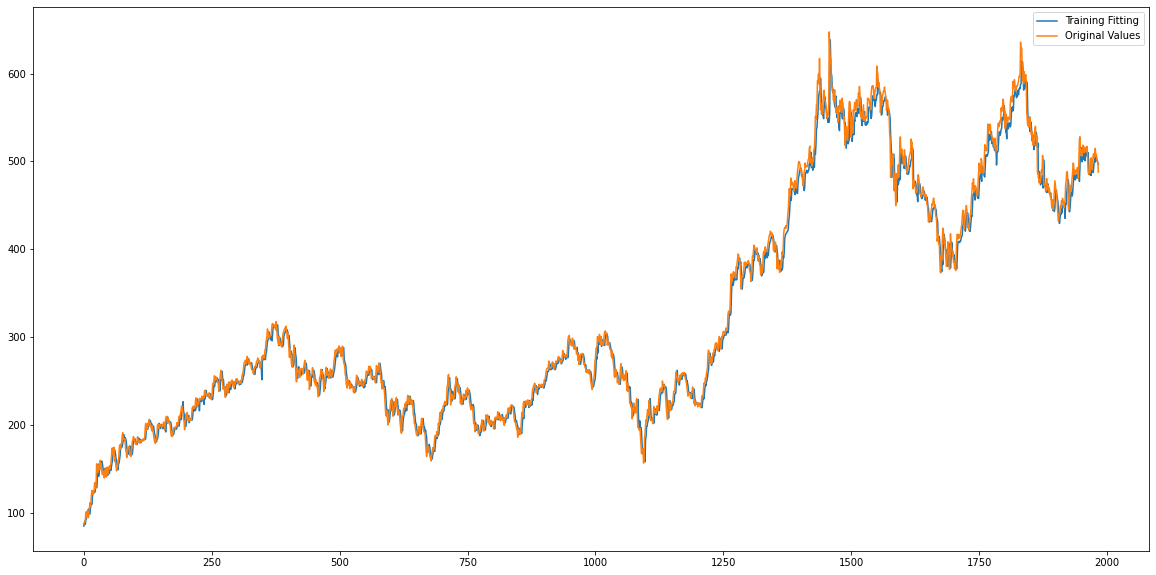

In [32]:
plt.figure(figsize=(20,10))
plt.plot(scaler.inverse_transform(training_predictions) , label='Training Fitting')
plt.plot(scaler.inverse_transform(np.array(y_train).reshape(-1,1)) ,label='Original Values')
plt.legend()
plt.show()

In [33]:
preds = lstm.predict(X_test)

In [34]:
print('Mean Squared Error : {}'.format(mean_squared_error(scaler.inverse_transform(np.array(y_test).reshape(-1,1)) ,scaler.inverse_transform(preds) )))
print('Mean Absolute Error : {}'.format(mean_absolute_error(scaler.inverse_transform(np.array(y_test).reshape(-1,1)) ,scaler.inverse_transform(preds))))

Mean Squared Error : 361.3997812497222
Mean Absolute Error : 14.414508706238738


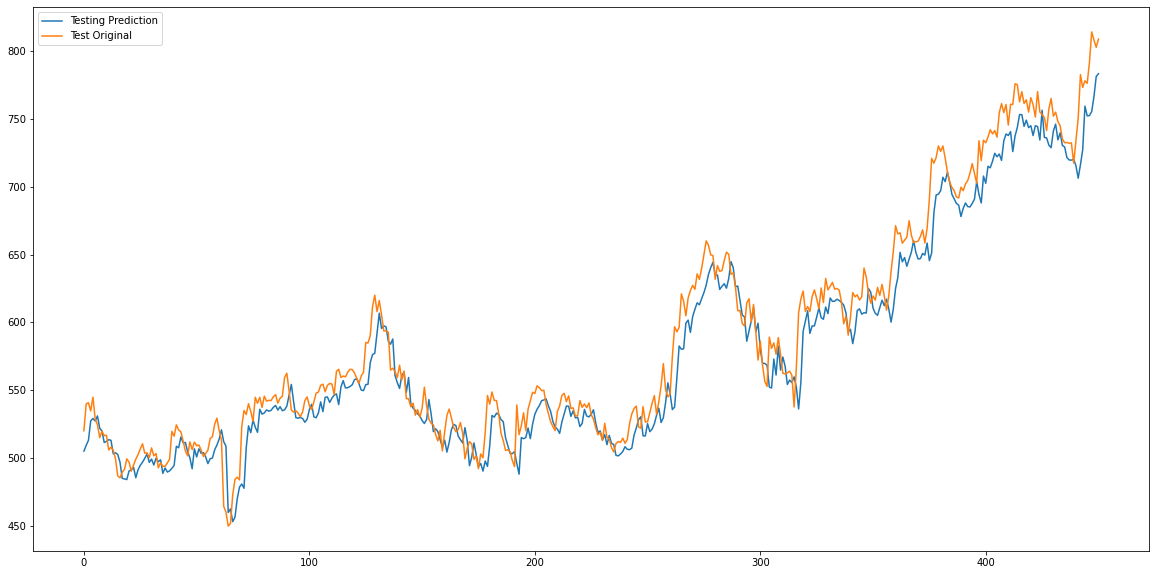

In [35]:
plt.figure(figsize=(20,10))
plt.plot(scaler.inverse_transform(preds) , label='Testing Prediction')
plt.plot(scaler.inverse_transform(np.array(y_test).reshape(-1,1)) ,label='Test Original')
plt.legend()
plt.show()

In [59]:
lstm.save('./models/AXISBANKEQ.h5')

In [36]:
scaled_original = scaler.inverse_transform(np.array(y_test).reshape(-1,1))
scaled_lstm = scaler.inverse_transform(preds)

In [37]:
scaled_original = scaled_original.reshape(1,-1).tolist()
scaled_lstm  = scaled_lstm.reshape(1,-1).tolist()

In [38]:
index = test[61:].index

In [39]:
data = {'Original':scaled_original[0] ,
        'Prediction': scaled_lstm[0]}

In [40]:
pred_df = pd.DataFrame(data=data , index =index)

In [41]:
diff = pred_df['Original'] - pred_df['Prediction']

In [42]:
print(diff.max())
print(diff.min())

70.9691040039063
-48.50853271484374


In [45]:
pred_df.to_csv('./outputs/axisbankout.csv')